## 5.3 순환 신경망을 사용한 텍스트 분류

### 순환 신경망 개념

이 텍스트 분류 튜토리얼은 감정 분석을 위해 [IMDB 대형 영화 리뷰 데이터세트](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network)로 [순환 신경망](http://ai.stanford.edu/~amaas/data/sentiment/)을 훈련합니다.

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

`matplotlib`을 가져오고 그래프를 플롯하는 helper 함수를 만듭니다.

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

### 입력 파이프라인 설정하기

IMDB 대형 영화 리뷰 데이터세트는 *binary classification* 데이터세트입니다. 모든 리뷰에는 *positive* 또는 *negative* 감정이 있습니다.

[TFDS](https://www.tensorflow.org/datasets)를 사용하여 데이터세트를 다운로드합니다.


In [6]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

데이터세트 `info`에는 인코더( `tfds.features.text.SubwordTextEncoder`)가 포함됩니다.

In [7]:
encoder = info.features['text'].encoder

In [8]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


이 텍스트 인코더는 문자열을 가역적으로 인코딩하여 필요한 경우 바이트 인코딩으로 돌아갑니다.

In [9]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [10]:
assert original_string == sample_string

In [11]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


### 데이터셋 준비 및 전처리

다음으로 이러한 인코딩된 문자열을 일괄적으로 생성합니다. `padded_batch` 메서드를 사용하여 배치에서 가장 긴 문자열의 길이로 시퀀스를 0으로 채웁니다.

In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [13]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

### 모델 만들기

`tf.keras.Sequential` 모델을 빌드하고 embedding 레이어로 시작합니다. embedding 레이어는 단어당 하나의 벡터를 저장합니다. 호출되면 단어 인덱스 시퀀스를 벡터 시퀀스로 변환합니다. 이들 벡터는 훈련 가능합니다. (충분한 데이터에 대해) 훈련 후, 유사한 의미를 가진 단어는 종종 비슷한 벡터를 갖습니다.

이 인덱스 조회는 원-핫 인코딩된 벡터를 `tf.keras.layers.Dense` 레이어를 통해 전달하는 동등한 연산보다 훨씬 효율적입니다.

RNN(Recurrent Neural Network)은 요소를 반복하여 시퀀스 입력을 처리합니다. RNN은 출력을 하나의 타임스텝에서 입력으로 전달한 다음, 다음 단계로 전달합니다.

`tf.keras.layers.Bidirectional` 래퍼도 RNN 레이어와 함께 사용할 수 있습니다. 이는 RNN 레이어를 통해 입력을 앞뒤로 전파한 다음 출력을 연결합니다. 이는 RNN이 장거리 종속성을 학습하는 데 도움이 됩니다.

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

모델의 모든 레이어에는 단일 입력만 있고 단일 출력이 생성되므로 여기서는 Keras 순차형 모델을 선택합니다. 상태 저장 RNN 레이어를 사용하려는 경우, Keras 함수 API 또는 모델 하위 클래스화를 사용하여 모델을 빌드하여 RNN 레이어 상태를 검색하고 재사용할 수 있습니다. 자세한 내용은 [Keras RNN 가이드](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse)를 확인하세요.

Keras 모델을 컴파일하여 훈련 프로세스를 구성합니다.

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 모델 훈련 및 평가

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 43s 107ms/step - loss: 0.6640 - accuracy: 0.5196 - val_loss: 0.5344 - val_accuracy: 0.7198
Epoch 2/10
391/391 [==============================] - 38s 97ms/step - loss: 0.3837 - accuracy: 0.8383 - val_loss: 0.3577 - val_accuracy: 0.8422
Epoch 3/10
391/391 [==============================] - 37s 95ms/step - loss: 0.2692 - accuracy: 0.8937 - val_loss: 0.3316 - val_accuracy: 0.8672
Epoch 4/10
391/391 [==============================] - 37s 95ms/step - loss: 0.2185 - accuracy: 0.9194 - val_loss: 0.3660 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 37s 95ms/step - loss: 0.1888 - accuracy: 0.9296 - val_loss: 0.3857 - val_accuracy: 0.8521
Epoch 6/10
391/391 [==============================] - 37s 95ms/step - loss: 0.1665 - accuracy: 0.9404 - val_loss: 0.3701 - val_accuracy: 0.8635
Epoch 7/10
391/391 [==============================] - 37s 95ms/step - loss: 0.1503 - accuracy: 0.9464 - val_loss: 0.3886 - val_accuracy

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 15s 38ms/step - loss: 0.4196 - accuracy: 0.8562
Test Loss: 0.41959404945373535
Test Accuracy: 0.8561599850654602


위의 모델은 시퀀스에 적용된 패딩을 마스킹하지 않습니다. 패딩된 시퀀스에 대해 훈련하고 패딩되지 않은 시퀀스를 테스트하면 왜곡될 수 있습니다. 이상적으로는 [마스킹을 사용](../../guide/keras/masking_and_padding)하여 이를 피할 수 있지만, 아래에서 볼 수 있듯이 출력에는 약간의 영향만 미칩니다.

예측값이 >= 0.5인 경우, 양성이고 그렇지 않으면 음성입니다.

In [19]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [20]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [21]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.3210312]]


In [22]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.30923536]]


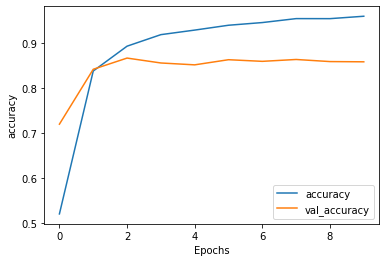

In [23]:
plot_graphs(history, 'accuracy')

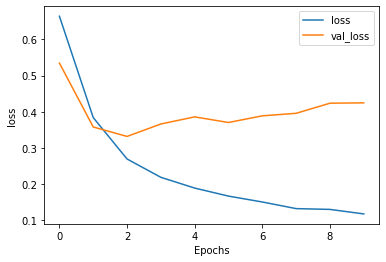

In [24]:
plot_graphs(history, 'loss')

## 두 개 이상의 LSTM 레이어 쌓기

Keras 반복 레이어에는 `return_sequences` 생성자 인수로 제어되는 두 가지 사용 가능한 모드가 있습니다.

- 각 타임스텝(형상 `(batch_size, timesteps, output_features)`의 3D 텐서)에 대한 전체 연속 출력 시퀀스를 반환합니다.
- 각 입력 시퀀스에 대한 마지막 출력만 반환합니다(형상 (batch_size, output_features)의 2D 텐서).

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 75s 181ms/step - loss: 0.6878 - accuracy: 0.5077 - val_loss: 0.5264 - val_accuracy: 0.7156
Epoch 2/10
391/391 [==============================] - 71s 181ms/step - loss: 0.4253 - accuracy: 0.8195 - val_loss: 0.3573 - val_accuracy: 0.8516
Epoch 3/10
391/391 [==============================] - 71s 181ms/step - loss: 0.2756 - accuracy: 0.8996 - val_loss: 0.4028 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 71s 181ms/step - loss: 0.2212 - accuracy: 0.9257 - val_loss: 0.3641 - val_accuracy: 0.8635
Epoch 5/10
391/391 [==============================] - 70s 179ms/step - loss: 0.1858 - accuracy: 0.9399 - val_loss: 0.4293 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 71s 180ms/step - loss: 0.1697 - accuracy: 0.9450 - val_loss: 0.4206 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 71s 181ms/step - loss: 0.1325 - accuracy: 0.9637 - val_loss: 0.4547 - val_ac

In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 34s 88ms/step - loss: 0.5311 - accuracy: 0.8513
Test Loss: 0.5311113595962524
Test Accuracy: 0.8513200283050537


In [29]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.735599]]


In [30]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-4.292017]]


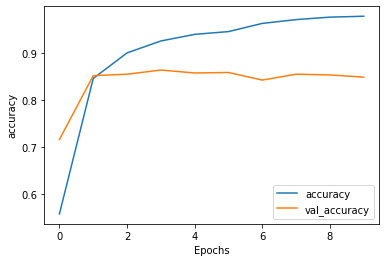

In [31]:
plot_graphs(history, 'accuracy')

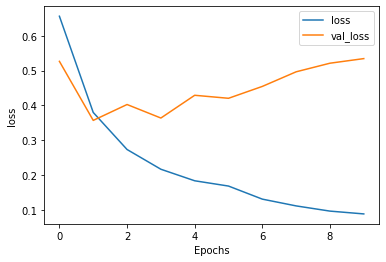

In [32]:
plot_graphs(history, 'loss')